# Import statements

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/paperspace/project1


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/mercari/'

In [4]:
!ls {PATH}

models	sample_submission.csv  test.tsv  tmp  train.tsv


In [5]:
train = pd.read_csv(f'{PATH}/train.tsv', sep='\t')

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [14]:
trn1 = train.sample(10)
len(trn1)

10

In [21]:
def foo(x):
    l = str(x).split("/")
    return pd.Series((l+['NA']*(4-len(l)))[:4])

train[['cat1', 'cat2', 'cat3', 'cat4']] = train['category_name'].apply(lambda x: foo(x))

In [22]:
test = pd.read_csv(f'{PATH}/test.tsv', sep='\t')
test[['cat1', 'cat2', 'cat3', 'cat4']] = test['category_name'].apply(lambda x: foo(x))
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,cat1,cat2,cat3,cat4
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings,NA
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,NA
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,NA
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,NA
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,NA


# Feature creation

In [23]:
#############
# taken out 'item_description'. Need NLP
#cat_vars = [ 'category_name',  'brand_name', 'shipping']
cat_vars = [ 'cat1', 'cat2', 'cat3', 'brand_name', 'shipping']
contin_vars = ['item_condition_id']

In [24]:
dep = 'price'
test[dep] = 0
joined = train[cat_vars+contin_vars+[dep,'name']].copy()
joined_test = test[cat_vars+contin_vars+[dep, 'name',  'test_id']].copy()

In [25]:
cat_vars+contin_vars+[dep,'name']

['cat1',
 'cat2',
 'cat3',
 'brand_name',
 'shipping',
 'item_condition_id',
 'price',
 'name']

In [26]:
######## NYI
# factors the individual columns (does not make sense for item_description need NLP??)
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [27]:
apply_cats(joined_test, joined)

In [28]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [29]:
#joined['item_condition_id'] = joined.item_condition_id.astype(np.int32)
#joined['shipping'] = joined.shipping.astype(np.int32)
#joined_test['item_condition_id'] = joined_test.item_condition_id.astype(np.int32)
#joined_test['shipping'] = joined_test.shipping.astype(np.int32)

In [30]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=0.2)
joined_samp = joined.iloc[idxs].set_index("name")
samp_size = len(joined_samp); samp_size

296507

In [31]:
#n = len(joined)
#samp_size = n
#joined_samp = joined

In [32]:
joined_samp.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id,price
name,,,,,,,
F/ship 4 Totoro Washi + 1 pen,Handmade,Paper Goods,Stationery,NaN,1,1.0,12.0
UCLA Men's Bundle + Shorts,Women,Other,Other,Adidas,1,1.0,76.0
Listing for lol,Beauty,Makeup,Lips,NaN,1,1.0,12.0
25 pcs kawaii sticker flakes,Kids,Toys,Arts & Crafts,NaN,1,1.0,3.0
Chanel Mini Lipgloss Set,Beauty,Makeup,Lips,Chanel,1,2.0,30.0


In [33]:
#??proc_df

In [34]:
len(joined_samp)

296507

In [35]:
joined_test = joined_test

In [36]:
joined_test = joined_test.set_index("name")
joined = joined.set_index("name")

In [37]:
df, y, nas, mapper = proc_df(joined, 'price', do_scale=True)
yl = np.log(y+1).astype('float32')

In [38]:
df_test, _, nas, mapper = proc_df(joined_test, 'price', do_scale=True, skip_flds=['test_id'],
                                  mapper=mapper, na_dict=nas)
#for n,c in joined_samp.items(): print(n), print(c)

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [40]:
val_idx[1:5]

[222381, 222382, 222383, 222384]

In [41]:
df.head()

,cat1,cat2,cat3,brand_name,shipping,item_condition_id
name,,,,,,
MLB Cincinnati Reds T Shirt Size XL,6,104,764,0,2,1.209777
Razer BlackWidow Chroma Keyboard,2,31,213,3558,1,1.209777
AVA-VIV Blouse,10,105,95,4181,2,-1.004675
Leather Horse Statues,4,56,405,0,2,-1.004675
24K GOLD plated rose,10,59,538,0,1,-1.004675


In [42]:
len(joined)

1482535

In [43]:
def exp_rmsle(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [44]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128, 
                                       test_df=df_test)

In [45]:
yl.dtype

dtype('float32')

In [46]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [47]:
cat_sz

[('cat1', 12),
 ('cat2', 115),
 ('cat3', 872),
 ('brand_name', 4810),
 ('shipping', 3)]

In [48]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [49]:
emb_szs

[(12, 6), (115, 50), (872, 50), (4810, 50), (3, 2)]

In [50]:
df.columns

Index(['cat1', 'cat2', 'cat3', 'brand_name', 'shipping', 'item_condition_id'], dtype='object')

In [51]:
cat_vars

['cat1', 'cat2', 'cat3', 'brand_name', 'shipping']

In [52]:
y_range

(0, 9.1270677566528313)

In [53]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1500,1000,500], [0.001,0.01,0.01], y_range=y_range)
lr = 1e-3

In [54]:
m.lr_find()

A Jupyter Widget

 61%|██████▏   | 1068/1738 [00:09<00:05, 114.63it/s, loss=1.72] 


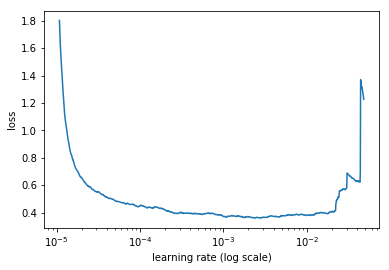

In [55]:
m.sched.plot()

In [56]:
lr=5.0e-5
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.36065  0.35247  0.59251]                           
[ 1.       0.334    0.32686  0.57049]                           
[ 2.       0.3201   0.32173  0.56601]                           
[ 3.       0.31909  0.32209  0.56627]                           
[ 4.       0.31596  0.31786  0.56258]                           
[ 5.       0.29835  0.31438  0.55947]                           
[ 6.       0.30538  0.31377  0.55894]                           



In [48]:
lr = 5.0e-4
m.fit(lr, 3, metrics=[exp_rmsle], cycle_len=2)

A Jupyter Widget

[ 0.       0.32404  0.31878  0.56345]                           
[ 1.       0.30513  0.31197  0.55732]                           
[ 2.       0.29919  0.31445  0.55954]                           
[ 3.       0.28376  0.31089  0.55636]                           
[ 4.       0.30098  0.3125   0.55779]                           
[ 5.       0.28833  0.31059  0.55608]                           



In [47]:
??md.get_learner